# Tutorial 4 - Solving ODEs

This fourth tutorial will go over how to solve first, second, and third order ODEs.

## 4.1 First Order ODEs

Although first order differential equations don't come up very often in fluid dynamics (or most subjects in physics), it's best to start there for this tutorial -- as we'll see, if you can solve a first order ODE, you can solve any higher order as well.

Consider, then, the simple equation
$$
\frac{du}{dy} = k,
$$
where $k$ is a constant.  We can solve this without numerical methods, of course; the solution for the function $u(y)$ is
$$
u(y) = ky + c_1,
$$
where $c_1$ is our single integration constant, which we can find with our boundary conditions.  If we suppose 
$$
u(0) = 0,
$$
then $c_1 = 0$.

How do we find this solution numerically?  I'll cover *Euler's method* here -- it's the lowest-order (and most error-prone) method of numerically solving ODEs, but it works fine in most cases we'll encounter.  The basic idea is to convert the $d$s in the differential equation to $\Delta$s:
$$
\frac{\Delta u}{\Delta y} = k.
$$
Then we can rearrange to get
$$
\Delta u = k \Delta y.
$$
If we know one point -- and we do, from our boundary condition $u(0) = 0$ -- we can build the function $u(y)$ up piece by piece by choosing a suitably small *stepsize* $\Delta y$ and finding $\Delta u$; the iterative solution is
$$
u_{i+1} = u_i + \Delta u = u_i + k \Delta y.
$$

Let's see how this works in code:

* Basic solving (using a fluids example with known solution; 1st order?  Then 2nd order?)
* Boundary conditions
* Advanced solving (boundary layer example)
* SciPy functions?

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

rc('text.latex',preamble='\\usepackage{libertine}\n\\usepackage[libertine]{newtxmath}')
rc('font',**{'family':'serif','serif':['Linux Libertine O']}, size=18)
rc('text', usetex=True)

Text(0, 0.5, '$u(y)$')

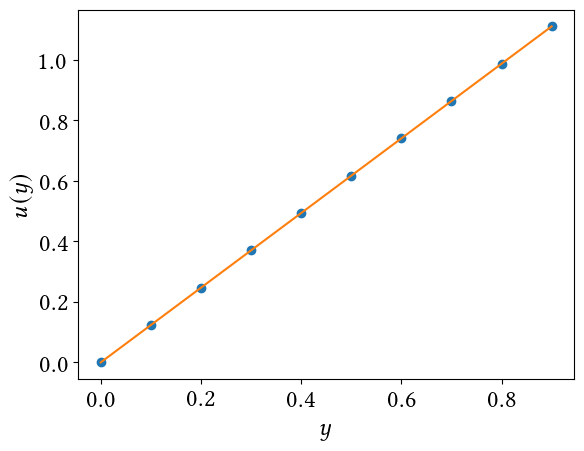

In [11]:
# set the value of the constant k
k = 1.234

# choose the step size, and the starting and ending point
dy = 0.1
y_i = 0.0
y_f = 1.0

# create NumPy arrays to hold our variables in
y = np.arange(y_i, y_f, dy)
u = np.zeros(len(y))

# set boundary condition
u[0] = 0

# iterate to find full solution between y_i and y_f
for i in range(len(y) - 1):
    du = k * dy
    u[i+1] = u[i] + du
    
# plot the results along with the analytical solution
plt.plot(y, u, "o")
plt.plot(y, k*y)
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

Now, maybe that was a little too simple.  Let's try the ODE
$$
\frac{du}{dy} = -u,
$$
which has the solution
$$
u(y) = A e^{-y}.
$$
We'll set our boundary condition so that $u(0) = 1$, in which case $A = 1$.  Let's try it:

Text(0, 0.5, '$u(y)$')

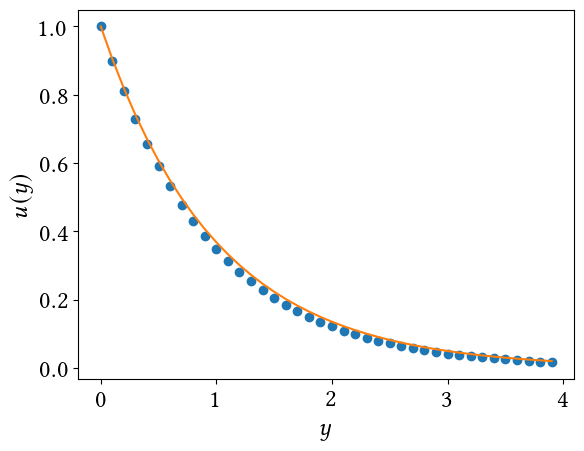

In [22]:
def decay(y, u):
    return -u

# change y_f
y_f = 4.0

y = np.arange(y_i, y_f, dy)
u = np.zeros(len(y))

# restart by setting the initial condition again; this time make it 1
u[0] = 1

for i in range(len(y) - 1):
    du = decay(y[i], u[i]) * dy
    u[i+1] = u[i] + du
    
plt.plot(y, u, "o")
plt.plot(y, np.exp(-y))
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

Now, it looks like the numerical solution differs from the correct by a little bit, especially in the middle.  We can fix that by choosing a smaller step size (or using a better algorithm than Euler).  But let's also build a function that solves a general first order ODE for us.  Here we go:

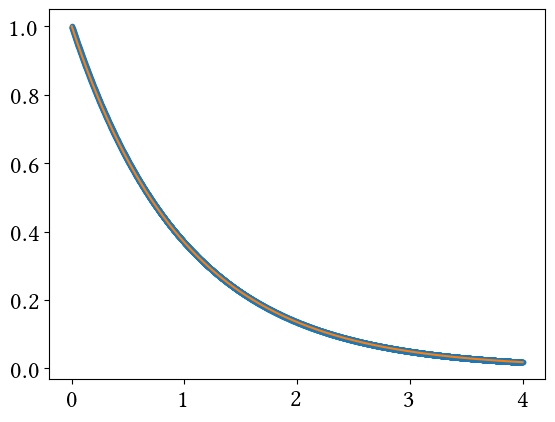

In [31]:
def solve_ode(fun, y_i, y_f, dy, u0):
    
    # create NumPy arrays to hold our variables in
    y = np.arange(y_i, y_f, dy)
    u = np.zeros(len(y))
    u[0] = u0
    
    for i in range(len(y) - 1):
        du = fun(y[i], u[i]) * dy
        u[i+1] = u[i] + du
    
    return y, u

# try it:
y, u = solve_ode(decay, 0, 4, 0.001, 1)
plt.plot(y, u, ".")
plt.plot(y, np.exp(-y))    

That's all there is to it -- making $dy$ smaller improves the accuracy, but at the expense of longer runtime and larger arrays.

What about higher order ODEs?

## 4.2 Second Order ODEs

Let's start with a nice simple second order ODE, which arrises in plane parallel Poiseuille flow:
$$
\frac{d^2u}{dy^2} = -k,
$$
with $k$ a constant.  The solution is simple to find, and is
$$
u(y) = -\frac{1}{2} k y^2 + c_1 y + c_2.
$$
If we take the boundary conditions as 
$$
u(0) = 0 \quad \text{and} \quad \left. \frac{du}{dy} \right|_{y=0} = 1,
$$
then $c_2 = 0$ and $c_1 = 1$, and the solution is
$$
u(y) = -\frac{1}{2} k y^2 + y.
$$

How do we solve this numerically?  The trick is to turn this second order ODE into two first order ODEs, which we can do by introducsing a new variable $a(y)$ such that
$$
\frac{du}{dy} = a(y).
$$
Along with the original equation,
$$
\frac{da}{dy} = -k,
$$
we now have two first order ODEs that are equivalent to the original second order one.

Each first order ODE can be solved in the same way we did above, with one extra thing to be careful of -- the equations are *coupled*, and so can't be solved independently.  Here's how we can do that:

Text(0, 0.5, '$u(y)$')

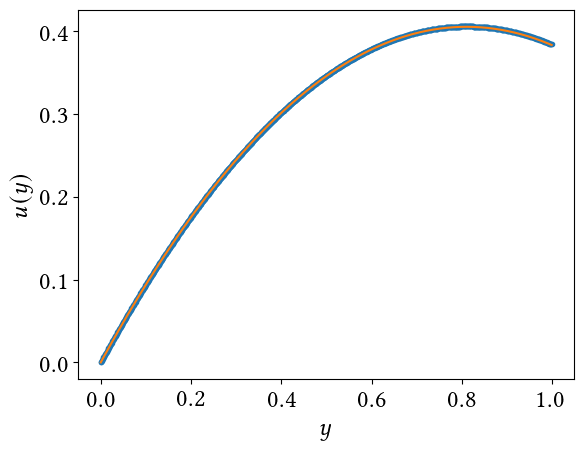

In [45]:
# set the value of the constant k
k = 1.234

def f1(y, u, a):
    return a

def f2(y, u, a):
    return -k

def solve_ivp2(fun1, fun2, y_i, y_f, dy, u0, a0): 
    
    # create NumPy arrays to hold our variables in
    y = np.arange(y_i, y_f, dy)
    u = np.zeros(len(y))
    a = np.zeros(len(y))

    # set boundary conditions
    u[0] = u0
    a[0] = a0
    
    # iterate to find full solution between y_i and y_f
    for i in range(len(y) - 1):
        du = fun1(y[i], u[i], a[i]) * dy
        da = fun2(y[i], u[i], a[i]) * dy
        u[i+1] = u[i] + du
        a[i+1] = a[i] + da
    
    return y, u, a

y, u, a = solve_ivp2(f1, f2, 0, 1, 0.001, 0, 1)

# plot the results along with the analytical solution
plt.plot(y, u, ".")
plt.plot(y, -0.5*k*y**2 + y)
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

## 4.3 Boundary Value Problems

Suppose, in the problem above, we instead had boundary conditions
$$
u(y) = 0 \quad \text{and} \quad u(1) = 0.
$$
Notice that we no longer have an *initial value problem*, in which we're given the initial value of the two functions we're looking for ($u$ and $a$), but have instead two boundary values given for one of the functions.

This is more difficult to solve, since we don't have any information about the initial value of $a$.  However, *some* value of $a_0 \equiv a(0)$ will lead to the second boundary $u(1) = 0$, and we can attempt to "guess" that value using what's called a *shooting method*.  

Let's give this a try, first just by guessing a couple of different values for $a_0$.

With a_0 = 0.1, the velocity at y = 0.999 is u = -0.5152502339999965
With a_0 = 2.0, the velocity at y = 0.999 is u = 1.3828497660000205


Text(0, 0.5, '$u(y)$')

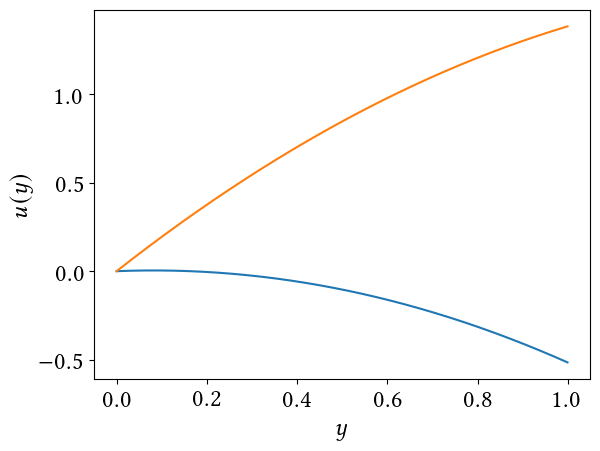

In [51]:
a_01 = 0.1
a_02 = 2.0
y1, u1, a1 = solve_ivp2(f1, f2, 0, 1, 0.001, 0, a_01)
y2, u2, a2 = solve_ivp2(f1, f2, 0, 1, 0.001, 0, a_02)

print(f"With a_0 = {a_01}, the velocity at y = {y1[-1]} is u = {u1[-1]}")
print(f"With a_0 = {a_02}, the velocity at y = {y2[-1]} is u = {u2[-1]}")
    
# plot the results along with the analytical solution
plt.plot(y1, u1)
plt.plot(y2, u2)
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

Well, clearly neither $a_0 = 0.1$ nor $a_0 = 2$ works perfectly.  Presumably -- and this is the key thing -- the correct value for $a_0$ lies between these two, and we can do a simple bisection search to find the value of $a_0$ within some tolerance.  Let try it.

In [59]:
def test_a(a0_left, a0_right, tol):
    # assumes correct value of a0 is between a_left and a_right
    # try it at the midpoint
    a0_mid = a0_left + 0.5 * (a0_right - a0_left)
    y_mid, u_mid, a_mid = solve_ivp2(f1, f2, 0, 1, 0.001, 0, a0_mid)
    print(f"a0_mid = {a0_mid}, u = {u_mid[-1]}")
    if abs(u_mid[-1]) < tol:
        return y_mid, u_mid, a_mid
    
    if u_mid[-1] > 0:
        return test_a(a0_left, a0_mid, tol)
    else:
        return test_a(a0_mid, a0_right, tol)
    
y, u, a = test_a(0.1, 2.0, 0.001)

a0_mid = 1.05, u = 0.4337997660000131
a0_mid = 0.5750000000000001, u = -0.04072523400000126
a0_mid = 0.8125, u = 0.19653726600000665
a0_mid = 0.6937500000000001, u = 0.07790601600000295
a0_mid = 0.6343750000000001, u = 0.0185903910000009
a0_mid = 0.6046875, u = -0.011067421500000191
a0_mid = 0.6195312500000001, u = 0.0037614847500003867
a0_mid = 0.6121093750000001, u = -0.003652968374999976
a0_mid = 0.6158203125000001, u = 5.425818750022721e-05


Text(0, 0.5, '$u(y)$')

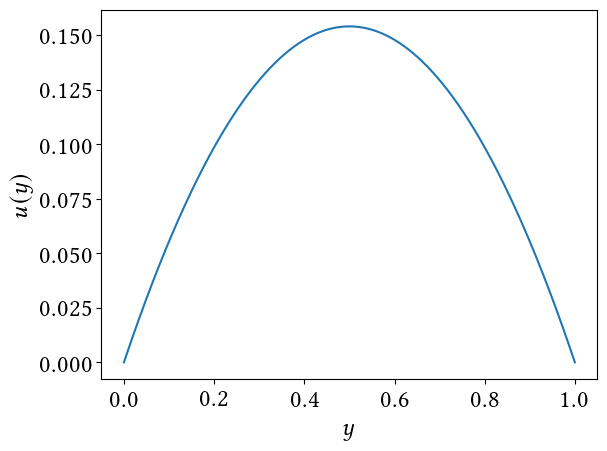

In [61]:
plt.plot(y, u)
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

## 4.4 Using SciPy

Rather than building our own code -- which is illustrative and fun! -- we can instead use methods from the SciPy package.  

For example, here's some code to solve the second order ODE with initial values from above.

Text(0, 0.5, '$u(y)$')

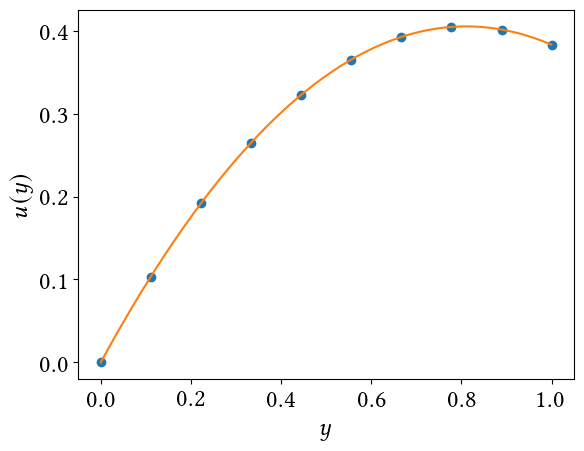

In [69]:
from scipy.integrate import solve_ivp

# this function combines f1 and f2 above
def fun(y, ua):
    u = ua[0]
    a = ua[1]
    
    return [a, -k]

y_i = 0
y_f = 1

# boundary conditions for u and a
u0 = 0
a0 = 1

sol = solve_ivp(fun, [y_i, y_f], [u0, a0], t_eval = np.linspace(0, 1, 10))
plt.plot(sol.t, sol.y[0], "o")
plt.plot(y, -0.5*k*y**2 + y)
plt.xlabel("$y$")
plt.ylabel("$u(y)$")

SciPy will also do boundary value problems, but I'll let you try that on your own.